In [28]:
#IMPORTS AND DATA 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLassoCV 
from sklearn.metrics import auc, roc_curve
from sklearn.linear_model import LassoCV


data = pd.read_csv("/Users/imose3/Desktop/from_github/Data_analysis/projekti/data.csv")
print(data.head())


   time    SWI5    CBF1    GAL4   GAL80    ASH1
0     0  0.0760  0.0419  0.0207  0.0225  0.1033
1    10  0.0186  0.0365  0.0122  0.0175  0.0462
2    20  0.0090  0.0514  0.0073  0.0165  0.0439
3    30  0.0117  0.0473  0.0079  0.0147  0.0371
4    40  0.0088  0.0482  0.0084  0.0145  0.0475


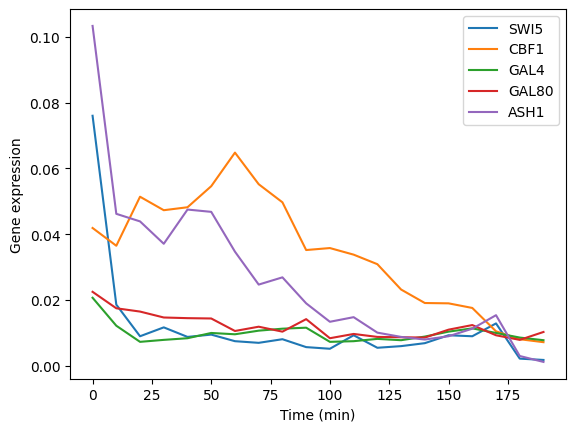

In [13]:
#DATA PLOTTED

gene = ["SWI5", "CBF1", "GAL4", "GAL80", "ASH1"]

for g in gene:
    plt.plot(data["time"], data[g], label=g)
#PLOT
plt.xlabel("Time (min)")
plt.ylabel("Gene expression")
plt.legend()
plt.show()


In [14]:
data_norm = data.copy()
#for g in gene:
#    data_norm[g] = data[g] / data[g].max()


In [20]:
#GGM METHOD

p = len(gene)
x1  = data_norm[gene].values[:-1]   
x2 = data_norm[gene].values[1:]   
x_lag = np.hstack([x1, x2])      
xz = StandardScaler().fit_transform(x_lag)

model = GraphicalLassoCV()
model.fit(xz)
Theta = model.precision_             

diag = np.diag(Theta)
eps = 1e-12
diag = np.maximum(diag, eps)               
D = np.sqrt(diag)
pc = -Theta / np.outer(D, D)
np.fill_diagonal(pc, 1.0)

# past -> future block
pclag = pc[:p, p:]             

edges = []
for i in range(p):          
    for j in range(p):      
        if i == j:
            continue
        score = abs(pclag[i, j])
        sign = np.sign(pclag[i, j])
        edges.append((gene[i], gene[j], score, sign))

edges = sorted(edges, key=lambda x: x[2], reverse=True)
edges_nonzero = [e for e in edges if e[2] > 1e-12]

print("alpha:", model.alpha_)
print("\npredicted directed edges that are non zero:")
for g1, g2, score, sign in edges_nonzero:
    print(f"{g1:5s} -> {g2:5s} | score={score:.3f} | sign={int(sign)}")


#RUNTIME WARNINGS 

if not np.isfinite(xz).all():
    raise ValueError("xz contains NaN or inf. Check scaling/normalization.")

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    # Numerical warnings are being observed due to the small sample size. However, all final estimates are finite and stable as no triggers are raised after the previous command


alpha: 0.20111186583426546

predicted directed edges that are non zero:
GAL80 -> ASH1  | score=0.239 | sign=1
GAL80 -> SWI5  | score=0.192 | sign=1
ASH1  -> GAL80 | score=0.173 | sign=1
CBF1  -> ASH1  | score=0.055 | sign=1
ASH1  -> SWI5  | score=0.040 | sign=1


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/covariance/_graph_lasso.py:167: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = -precision_[idx, idx] * coefs
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/covariance/_graph_lasso.py:168: RuntimeWarning: invalid value encountered in multiply
  precision_[idx, indices != idx] = -precision_[idx, idx] * coefs
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/_core/_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [22]:
#clear visual for report >  this creates the ranked list of predicted edges

from IPython.display import display, HTML

edges_df = pd.DataFrame(edges, columns=["gene1", "gene2", "absolute partial correlation score", "sign"])
edges_df = edges_df[edges_df["absolute partial correlation score"] > 1e-12].copy()
edges_df["sign"] = edges_df["sign"].map({1.0: "+", -1.0: "-", 0.0: "0"})
edges_df = edges_df.sort_values("absolute partial correlation score", ascending=False).reset_index(drop=True)

display(HTML(edges_df.to_html(index=False, border=1)))

#print(edges_df.to_string(index=False))

#edges_df.to_csv("gene_interactiw11ons_table.csv", index=False)



gene1,gene2,absolute partial correlation score,sign
GAL80,ASH1,0.238534,+
GAL80,SWI5,0.191866,+
ASH1,GAL80,0.172525,+
CBF1,ASH1,0.054834,+
ASH1,SWI5,0.040423,+


AUC: 0.44047619047619047
tau: 0.0
fp at tau: 14


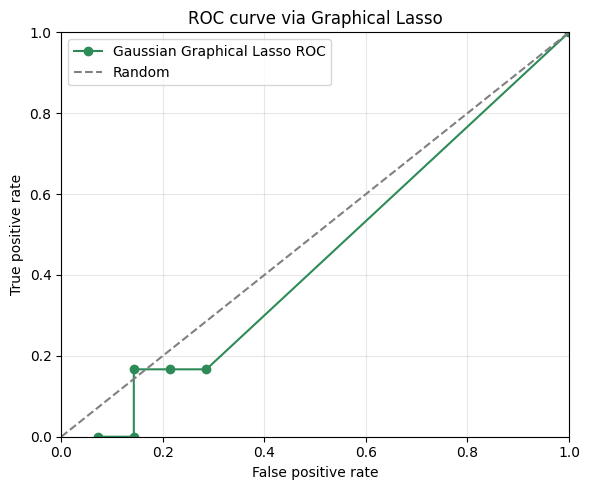

In [24]:
#GGM ROC CURVE & PLOT

p = len(gene)
true_edges = { ("CBF1","GAL4"), ("GAL4","SWI5"), ("SWI5","ASH1"),
 ("ASH1","GAL80"), ("GAL80","GAL4"), ("ASH1","CBF1")}

P = len(true_edges)
N_neg = p*(p-1) - P  
all_edges = []
scores = []
y_true = []

for i in range(p):
    for j in range(p):
        if i == j:
            continue
        e = (gene[i], gene[j])
        s = float(abs(pclag[i, j]))  
        all_edges.append(e)
        scores.append(s)
        y_true.append(1 if e in true_edges else 0)

scores = np.array(scores)
y_true = np.array(y_true)
thresholds = np.unique(scores)[::-1]  
thresholds = np.r_[thresholds, -np.inf]  

tpr = []
fpr = []

for tau in thresholds:
    y_pred = (scores >= tau).astype(int)
    TP = np.sum((y_pred == 1) & (y_true == 1))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    tpr.append(TP / P if P > 0 else 0.0)
    fpr.append(FP / N_neg if N_neg > 0 else 0.0)

tpr = np.array(tpr)
fpr = np.array(fpr)
order = np.argsort(fpr)
auc = np.trapezoid(tpr[order], fpr[order])

print("AUC:", auc)

if P > 0:
    true_scores = [scores[k] for k, e in enumerate(all_edges) if e in true_edges]
    tau_star = min(true_scores)
    y_pred_star = (scores >= tau_star).astype(int)
    FP_star = np.sum((y_pred_star == 1) & (y_true == 0))
    print("tau:", tau_star)
    print("fp at tau:", FP_star)
    auc_val = np.trapezoid(tpr[order], fpr[order])
    #print("AUC:", auc_val)

    #print("TPR:", true_pr)
    #print("FPR:", false_pr)



plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, marker="o", color="seagreen", label="Gaussian Graphical Lasso ROC")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve via Graphical Lasso")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [32]:
#VAR(1) METHOD

x_t  = data_norm[gene].values[:-1, :]   
y_t1 = data_norm[gene].values[1:,  :]   
p = len(gene)
xxz = StandardScaler().fit_transform(x_t)

A = np.zeros((p, p))       
alphas = np.zeros(p)

for j in range(p):
    model = LassoCV(cv=min(5, len(xxz)), random_state=0).fit(xxz, y_t1[:, j])
    A[j, :] = model.coef_
    alphas[j] = model.alpha_

edges = []
for i in range(p):
    for j in range(p):
        if i == j:
            continue
        score = float(abs(A[j, i]))          
        sign  = int(np.sign(A[j, i]))        
        edges.append((gene[i], gene[j], score, sign))

edges_sorted = sorted(edges, key=lambda x: x[2], reverse=True)

df_edges = pd.DataFrame(edges_sorted, columns=["regulator", "target", "score", "sign"])
print("alphas:")
print(pd.Series(alphas, index=gene))
print("\nranked predicted directed edges:")
print(df_edges.head(20))


alphas:
SWI5     0.000150
CBF1     0.000039
GAL4     0.000153
GAL80    0.000063
ASH1     0.000013
dtype: float64

ranked predicted directed edges:
   regulator target     score  sign
0       ASH1   CBF1  0.010623     1
1       SWI5   CBF1  0.009715    -1
2      GAL80   ASH1  0.008964     1
3       GAL4   ASH1  0.004660    -1
4       SWI5   ASH1  0.004227    -1
5      GAL80   CBF1  0.002907     1
6       CBF1   ASH1  0.001738     1
7       ASH1  GAL80  0.001504     1
8      GAL80   SWI5  0.001460     1
9       GAL4   CBF1  0.000706    -1
10      CBF1   GAL4  0.000272     1
11      GAL4  GAL80  0.000237    -1
12     GAL80   GAL4  0.000213    -1
13      CBF1   SWI5  0.000073     1
14      CBF1  GAL80  0.000019     1
15      SWI5   GAL4  0.000000     0
16      SWI5  GAL80  0.000000     0
17      GAL4   SWI5  0.000000     0
18      ASH1   SWI5  0.000000     0
19      ASH1   GAL4  0.000000     0



AUC: 0.5833333333333334
tau: 0.0
fp at tau: 14


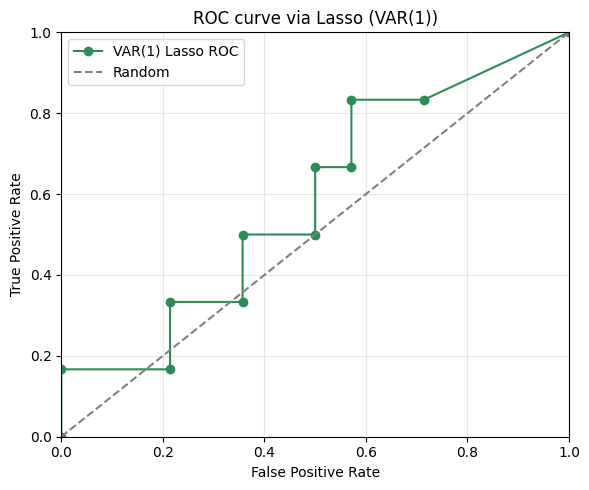

In [33]:
#VAR(1) ROC CURVE & PLOT

true_edges = { ("CBF1","GAL4"), ("GAL4","SWI5"), ("SWI5","ASH1"), ("ASH1","GAL80"), ("GAL80","GAL4"), ("ASH1","CBF1")}

y_true = np.array([1 if (r,t) in true_edges else 0 for (r,t,_,_) in edges_sorted])
scores = np.array([s for (_,_,s,_) in edges_sorted], dtype=float)

fpr, tpr, thr = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)
print("\nAUC:", roc_auc)

true_scores = [s for (r,t,s,_) in edges_sorted if (r,t) in true_edges]
if len(true_scores) > 0:
    tau_star = min(true_scores)
    y_pred_star = (scores >= tau_star).astype(int)
    FP_star = int(np.sum((y_pred_star == 1) & (y_true == 0)))
    print("tau:", tau_star)
    print("fp at tau:", FP_star)
else:
    print("-")



plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, marker="o", color="seagreen", label="VAR(1) Lasso ROC")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve via Lasso (VAR(1))")
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()